# Setup

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import glob
import random

In [4]:
# Load array
x_train = np.load('./input_data/x_train.npy')
x_val = np.load('./input_data/x_val.npy')
x_test = np.load('./input_data/x_test.npy')
b_ins = np.load('./input_data/b_ins.npy')
om_ins = np.load('./input_data/om_ins.npy')

# Neural Network

In [5]:
size = 1001

In [36]:
num_hidden_layers = 3
encoding_dim = 3
hidden_dim = 80
batch_size = 32
epochs = 500
learning_rate = 0.001

factor = 0.2
patience = 40
min_lr = 0.000001
verbose = 1

In [37]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=factor,
                                                 patience=patience, 
                                                 min_lr=min_lr, 
                                                 verbose=verbose
                                                )

In [38]:
checkpoint_filepath = '/tmp/ckpt/checkpoint.weights.h5'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    verbose=verbose
    )

In [39]:
early_stopping_callback = EarlyStopping(
    patience=100,
    monitor='val_loss',
    mode='min',
    verbose=verbose
)

## Autoencoder

In [40]:
def build_autoencoder(size, encoding_dim, hidden_dim, num_hidden_layers, dropout_rate=0.05):
    # input
    input_img = keras.Input(shape=(size,))

    # encoder
    encoded = input_img
    for _ in range(num_hidden_layers):
        encoded = layers.Dense(hidden_dim, activation='relu')(encoded)
        encoded = layers.Dropout(dropout_rate)(encoded)

    # bottleneck layer has 32 neurons (encoding dim)
    bottleneck = layers.Dense(encoding_dim, activation='linear')(encoded)

    # decoder
    decoded = bottleneck
    for _ in range(num_hidden_layers):
        decoded = layers.Dense(hidden_dim, activation='relu')(decoded)
        decoded = layers.Dropout(dropout_rate)(decoded)

    # output
    output_img = layers.Dense(size, activation='linear')(decoded)
    autoencoder = keras.Model(input_img, output_img)

    encoder = keras.Model(input_img, bottleneck)

    encoded_input = keras.Input(shape=(encoding_dim,))
   
  #decoder_input = keras.Input(shape=(encoding_dim,))
#     decoder = decoder_input
#     for i in range(-2, 0, 1):
#         decoder = autoencoder.layers[i](decoder)
    
    decoder_layer = autoencoder.layers[-2]
    decoder = decoder_layer(encoded_input)
    for _ in range(num_hidden_layers - 1):
        decoder = layers.Dense(hidden_dim, activation='relu')(decoder)
        decoder = layers.Dropout(dropout_rate)(decoder)

    decoder_output = autoencoder.layers[-1](decoder)
    
#     decoder_input = keras.Input(shape=(encoding_dim,))
#     decoded = decoder_input
#     for _ in range(num_hidden_layers):
#         decoded = autoencoder.layers[-2 - _](decoded)

#     decoder_output = autoencoder.layers[-1](decoded)
    
    decoder_model = keras.Model(encoded_input, decoder_output)

    return autoencoder, encoder, decoder_model

autoencoder, encoder, decoder_model = build_autoencoder(size, encoding_dim, hidden_dim, num_hidden_layers)

In [41]:
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                    loss='mae')

## training the model

In [42]:
fitting_output = autoencoder.fit(x_train, x_train, 
                                 epochs=epochs,
                                 batch_size=batch_size,
                                 shuffle=True,
                                 validation_data=(x_val, x_val),
                                 callbacks=[reduce_lr, model_checkpoint_callback, early_stopping_callback])

Epoch 1/500
15/22 [===================>..........] - ETA: 0s - loss: 0.0472 
Epoch 1: val_loss improved from inf to 0.05159, saving model to /tmp/ckpt/checkpoint.weights.h5
22/22 [==============================] - 2s 16ms/step - loss: 0.0519 - val_loss: 0.0516 - lr: 0.0010
Epoch 2/500
12/22 [===============>..............] - ETA: 0s - loss: 0.0453
Epoch 2: val_loss improved from 0.05159 to 0.04792, saving model to /tmp/ckpt/checkpoint.weights.h5
22/22 [==============================] - 0s 9ms/step - loss: 0.0491 - val_loss: 0.0479 - lr: 0.0010
Epoch 3/500
13/22 [================>.............] - ETA: 0s - loss: 0.0470
Epoch 3: val_loss improved from 0.04792 to 0.04701, saving model to /tmp/ckpt/checkpoint.weights.h5
22/22 [==============================] - 0s 10ms/step - loss: 0.0475 - val_loss: 0.0470 - lr: 0.0010
Epoch 4/500
14/22 [==================>...........] - ETA: 0s - loss: 0.0461
Epoch 4: val_loss did not improve from 0.04701
22/22 [==============================] - 0s 6ms/st

Epoch 33/500
19/22 [========================>.....] - ETA: 0s - loss: 0.0336
Epoch 33: val_loss improved from 0.03260 to 0.03207, saving model to /tmp/ckpt/checkpoint.weights.h5
22/22 [==============================] - 0s 7ms/step - loss: 0.0336 - val_loss: 0.0321 - lr: 0.0010
Epoch 34/500
20/22 [==========================>...] - ETA: 0s - loss: 0.0324
Epoch 34: val_loss improved from 0.03207 to 0.02991, saving model to /tmp/ckpt/checkpoint.weights.h5
22/22 [==============================] - 0s 7ms/step - loss: 0.0326 - val_loss: 0.0299 - lr: 0.0010
Epoch 35/500
19/22 [========================>.....] - ETA: 0s - loss: 0.0323
Epoch 35: val_loss did not improve from 0.02991
22/22 [==============================] - 0s 4ms/step - loss: 0.0324 - val_loss: 0.0335 - lr: 0.0010
Epoch 36/500
19/22 [========================>.....] - ETA: 0s - loss: 0.0331
Epoch 36: val_loss did not improve from 0.02991
22/22 [==============================] - 0s 4ms/step - loss: 0.0338 - val_loss: 0.0315 - lr: 0

22/22 [==============================] - 0s 4ms/step - loss: 0.0289 - val_loss: 0.0280 - lr: 0.0010
Epoch 68/500
19/22 [========================>.....] - ETA: 0s - loss: 0.0287
Epoch 68: val_loss did not improve from 0.02587
22/22 [==============================] - 0s 4ms/step - loss: 0.0288 - val_loss: 0.0263 - lr: 0.0010
Epoch 69/500
18/22 [=======================>......] - ETA: 0s - loss: 0.0298
Epoch 69: val_loss did not improve from 0.02587
22/22 [==============================] - 0s 4ms/step - loss: 0.0290 - val_loss: 0.0271 - lr: 0.0010
Epoch 70/500
18/22 [=======================>......] - ETA: 0s - loss: 0.0281
Epoch 70: val_loss did not improve from 0.02587
22/22 [==============================] - 0s 4ms/step - loss: 0.0284 - val_loss: 0.0272 - lr: 0.0010
Epoch 71/500
18/22 [=======================>......] - ETA: 0s - loss: 0.0306
Epoch 71: val_loss did not improve from 0.02587
22/22 [==============================] - 0s 4ms/step - loss: 0.0296 - val_loss: 0.0303 - lr: 0.0010


22/22 [==============================] - 0s 6ms/step - loss: 0.0260 - val_loss: 0.0216 - lr: 0.0010
Epoch 103/500
 1/22 [>.............................] - ETA: 0s - loss: 0.0241
Epoch 103: val_loss did not improve from 0.02160
22/22 [==============================] - 0s 3ms/step - loss: 0.0249 - val_loss: 0.0228 - lr: 0.0010
Epoch 104/500
 1/22 [>.............................] - ETA: 0s - loss: 0.0299
Epoch 104: val_loss did not improve from 0.02160
22/22 [==============================] - 0s 3ms/step - loss: 0.0253 - val_loss: 0.0223 - lr: 0.0010
Epoch 105/500
 1/22 [>.............................] - ETA: 0s - loss: 0.0223
Epoch 105: val_loss did not improve from 0.02160
22/22 [==============================] - 0s 3ms/step - loss: 0.0251 - val_loss: 0.0230 - lr: 0.0010
Epoch 106/500
 1/22 [>.............................] - ETA: 0s - loss: 0.0285
Epoch 106: val_loss did not improve from 0.02160
22/22 [==============================] - 0s 3ms/step - loss: 0.0253 - val_loss: 0.0233 - lr:

22/22 [==============================] - 0s 3ms/step - loss: 0.0236 - val_loss: 0.0240 - lr: 0.0010
Epoch 138/500
 1/22 [>.............................] - ETA: 0s - loss: 0.0268
Epoch 138: val_loss did not improve from 0.02081
22/22 [==============================] - 0s 3ms/step - loss: 0.0249 - val_loss: 0.0227 - lr: 0.0010
Epoch 139/500
 1/22 [>.............................] - ETA: 0s - loss: 0.0336
Epoch 139: val_loss did not improve from 0.02081
22/22 [==============================] - 0s 3ms/step - loss: 0.0242 - val_loss: 0.0217 - lr: 0.0010
Epoch 140/500
 1/22 [>.............................] - ETA: 0s - loss: 0.0182
Epoch 140: val_loss did not improve from 0.02081
22/22 [==============================] - 0s 3ms/step - loss: 0.0242 - val_loss: 0.0242 - lr: 0.0010
Epoch 141/500
 1/22 [>.............................] - ETA: 0s - loss: 0.0134
Epoch 141: val_loss did not improve from 0.02081
22/22 [==============================] - 0s 3ms/step - loss: 0.0245 - val_loss: 0.0226 - lr:

Epoch 173/500
 1/22 [>.............................] - ETA: 0s - loss: 0.0141
Epoch 173: val_loss did not improve from 0.01985
22/22 [==============================] - 0s 4ms/step - loss: 0.0239 - val_loss: 0.0211 - lr: 0.0010
Epoch 174/500
 1/22 [>.............................] - ETA: 0s - loss: 0.0248
Epoch 174: val_loss did not improve from 0.01985
22/22 [==============================] - 0s 3ms/step - loss: 0.0231 - val_loss: 0.0199 - lr: 0.0010
Epoch 175/500
 1/22 [>.............................] - ETA: 0s - loss: 0.0140
Epoch 175: val_loss did not improve from 0.01985
22/22 [==============================] - 0s 3ms/step - loss: 0.0228 - val_loss: 0.0221 - lr: 0.0010
Epoch 176/500
 1/22 [>.............................] - ETA: 0s - loss: 0.0218
Epoch 176: val_loss did not improve from 0.01985
22/22 [==============================] - 0s 3ms/step - loss: 0.0229 - val_loss: 0.0233 - lr: 0.0010
Epoch 177/500
21/22 [===========================>..] - ETA: 0s - loss: 0.0245
Epoch 177: val

 1/22 [>.............................] - ETA: 0s - loss: 0.0177
Epoch 244: val_loss did not improve from 0.01855
22/22 [==============================] - 0s 3ms/step - loss: 0.0208 - val_loss: 0.0194 - lr: 0.0010
Epoch 245/500
 1/22 [>.............................] - ETA: 0s - loss: 0.0260
Epoch 245: val_loss did not improve from 0.01855
22/22 [==============================] - 0s 3ms/step - loss: 0.0229 - val_loss: 0.0197 - lr: 0.0010
Epoch 246/500
 1/22 [>.............................] - ETA: 0s - loss: 0.0187
Epoch 246: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 246: val_loss did not improve from 0.01855
22/22 [==============================] - 0s 3ms/step - loss: 0.0221 - val_loss: 0.0195 - lr: 0.0010
Epoch 247/500
 1/22 [>.............................] - ETA: 0s - loss: 0.0153
Epoch 247: val_loss did not improve from 0.01855
22/22 [==============================] - 0s 3ms/step - loss: 0.0208 - val_loss: 0.0187 - lr: 2.0000e-04
Epoch 248/500
 1/22 [>

 1/22 [>.............................] - ETA: 0s - loss: 0.0204
Epoch 313: val_loss did not improve from 0.01755
22/22 [==============================] - 0s 3ms/step - loss: 0.0207 - val_loss: 0.0183 - lr: 2.0000e-04
Epoch 314/500
 1/22 [>.............................] - ETA: 0s - loss: 0.0433
Epoch 314: val_loss did not improve from 0.01755
22/22 [==============================] - 0s 3ms/step - loss: 0.0213 - val_loss: 0.0185 - lr: 2.0000e-04
Epoch 315/500
 1/22 [>.............................] - ETA: 0s - loss: 0.0191
Epoch 315: val_loss did not improve from 0.01755
22/22 [==============================] - 0s 3ms/step - loss: 0.0203 - val_loss: 0.0181 - lr: 2.0000e-04
Epoch 316/500
 1/22 [>.............................] - ETA: 0s - loss: 0.0169
Epoch 316: val_loss improved from 0.01755 to 0.01745, saving model to /tmp/ckpt/checkpoint.weights.h5
22/22 [==============================] - 0s 6ms/step - loss: 0.0204 - val_loss: 0.0175 - lr: 2.0000e-04
Epoch 317/500
 1/22 [>...............

 1/22 [>.............................] - ETA: 0s - loss: 0.0207
Epoch 383: val_loss did not improve from 0.01745
22/22 [==============================] - 0s 4ms/step - loss: 0.0201 - val_loss: 0.0177 - lr: 4.0000e-05
Epoch 384/500
 1/22 [>.............................] - ETA: 0s - loss: 0.0226
Epoch 384: val_loss did not improve from 0.01745
22/22 [==============================] - 0s 3ms/step - loss: 0.0203 - val_loss: 0.0177 - lr: 4.0000e-05
Epoch 385/500
 1/22 [>.............................] - ETA: 0s - loss: 0.0249
Epoch 385: val_loss did not improve from 0.01745
22/22 [==============================] - 0s 3ms/step - loss: 0.0204 - val_loss: 0.0177 - lr: 4.0000e-05
Epoch 386/500
 1/22 [>.............................] - ETA: 0s - loss: 0.0178
Epoch 386: val_loss did not improve from 0.01745
22/22 [==============================] - 0s 3ms/step - loss: 0.0207 - val_loss: 0.0176 - lr: 4.0000e-05
Epoch 387/500
 1/22 [>.............................] - ETA: 0s - loss: 0.0208
Epoch 387: v

In [43]:
training_history = fitting_output.history

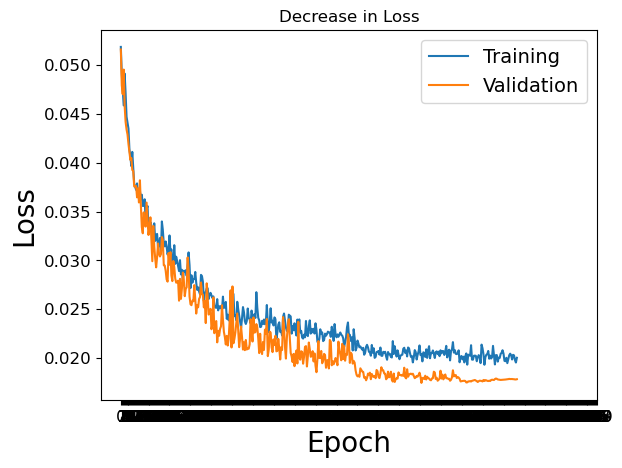

In [44]:
# plotting the decrease in loss as the network learns
fig_loss = plt.figure()
ax = fig_loss.add_subplot(111)
ax.plot(fitting_output.history['loss'], label='Training')
ax.plot(fitting_output.history['val_loss'], label='Validation')
ax.set_title('Decrease in Loss')
ax.set_ylabel('Loss', fontsize=20)
ax.set_xlabel('Epoch', fontsize=20)
ax.legend(loc='upper right', fontsize=14)
ax.tick_params(axis='both', which='both', labelsize=12)
ax.set_xticks(np.arange(0, epochs, 1))
#ax.set_ylim(0, 0.3)
plt.show()

## testing the model

In [45]:
encoded_data = encoder.predict(x_train)

22/22 [==============================] - 0s 2ms/step


In [46]:
encoded_data_to_plot = encoded_data.T
encoded_data_to_plot[0]
x_ec = encoded_data_to_plot[0]
y_ec = encoded_data_to_plot[1]

In [47]:
encoded_data_to_plot

array([[ 0.07414921,  0.24100554,  0.06668668, ...,  0.05544702,
         1.2347927 ,  0.40257737],
       [ 0.19512846,  0.22815667,  0.18749408, ...,  0.21291281,
        -2.702302  , -0.99577785],
       [ 0.38675544, -0.03146043,  0.3766128 , ...,  0.36785093,
         0.7792997 , -0.681699  ]], dtype=float32)

In [48]:
# plt.scatter(x_ec, om_ins[test_ind], label='original')
# # plt.scatter(x_ec, y_ec, label='encoded')
# plt.legend(loc='upper right')
# # plt.xlim(-0.3, -0.1)
# plt.show()

In [49]:
decoded_data = decoder_model.predict(encoded_data)

22/22 [==============================] - 0s 1ms/step


In [50]:
autoencoder.evaluate(x_train, x_train)

22/22 [==============================] - 0s 2ms/step - loss: 0.0179


0.017916632816195488

In [51]:
print(x_test.shape)
print(decoded_data.shape)

(150, 1001)
(704, 1001)


In [52]:
final = autoencoder.predict(x_test)

5/5 [==============================] - 0s 1ms/step


In [54]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(704, 1001)
(213, 1001)
(150, 1001)


In [55]:
704+213+150

1067

In [56]:
om_ins_tr = om_ins[0:704]
b_ins_tr = b_ins[0:704]

In [57]:
b_ins_tr.shape

(704,)

In [58]:
print("Shape of om_ins:", om_ins.shape)
print("Shape of encoded_data[:, 0]:", encoded_data[:, 0].shape)


Shape of om_ins: (1067,)
Shape of encoded_data[:, 0]: (704,)


In [77]:
fig = plt.figure(figsize=(12, 12))

ax1 = fig.add_subplot(331)
ax1.plot(om_ins_tr, encoded_data[:, 0], 'o', alpha=0.2)
ax1.set_title('om_ins, 0')

ax2 = fig.add_subplot(334)
ax2.plot(b_ins_tr, encoded_data[:, 0], 'o', alpha=0.2)
ax2.set_title('b_ins, 0')

ax3 = fig.add_subplot(332)
ax3.plot(om_ins_tr, encoded_data[:, 1], 'o', alpha=0.2)
ax3.set_title('om_ins, 1')

ax4 = fig.add_subplot(335)
ax4.plot(b_ins_tr, encoded_data[:, 1], 'o', alpha=0.2)
ax4.set_title('b_ins, 1')

ax5 = fig.add_subplot(333)
ax5.plot(om_ins_tr, encoded_data[:, 2], 'o', alpha=0.2)
ax5.set_title('om_ins, 2')

ax6 = fig.add_subplot(336)
ax6.plot(b_ins_tr, encoded_data[:, 2], 'o', alpha=0.2)
ax6.set_title('b_ins, 2')

ax7 = fig.add_subplot(337, projection='3d')
ax7.scatter(om_ins_tr, b_ins_tr, encoded_data[:, 0], c=encoded_data[:, 0])
ax7.set_title('om_ins, b_ins, 0')

ax8 = fig.add_subplot(338, projection='3d')
ax8.scatter(om_ins_tr, b_ins_tr, encoded_data[:, 1], c=encoded_data[:, 1])
ax8.set_title('om_ins, b_ins, 1')

ax9 = fig.add_subplot(339, projection='3d')
ax9.scatter(om_ins_tr, b_ins_tr, encoded_data[:, 2], c=encoded_data[:, 2])
ax9.set_title('om_ins, b_ins, 2')

plt.tight_layout()
plt.show()
# graphs_file_path = 'autoencoder_dp'
# plt.savefig(os.path.join(f"{graphs_file_path}.png"))
plt.close(fig)

139


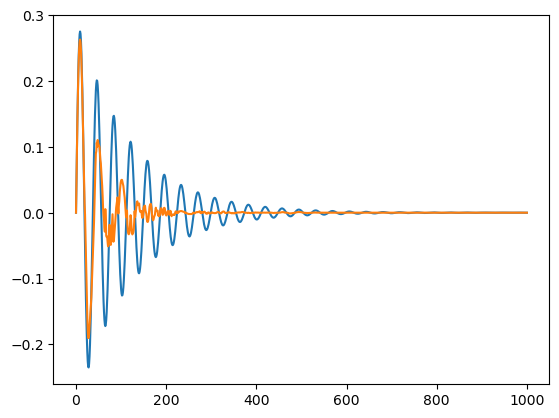

In [75]:
i = random.randint(0, 149)
print(i)

plt.plot(x_test[i])
plt.plot(final[i])
# plt.plot(x_test[i+1])
# plt.plot(decoded_data[i+1])
# plt.plot(x_test[i+2])
# plt.plot(decoded_data[i+2])

working really well for plots that don't have a high frequency or high decay rate

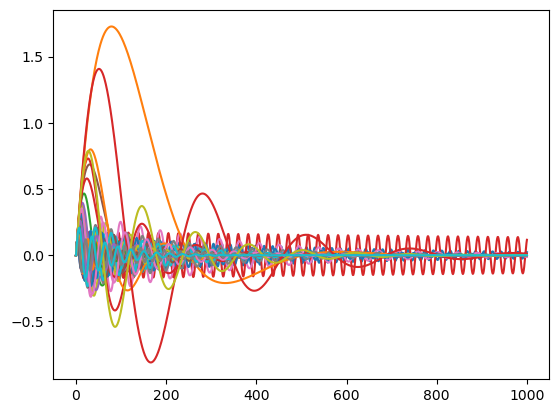

In [22]:
for i in range(40):
    plt.plot(x_test[i])

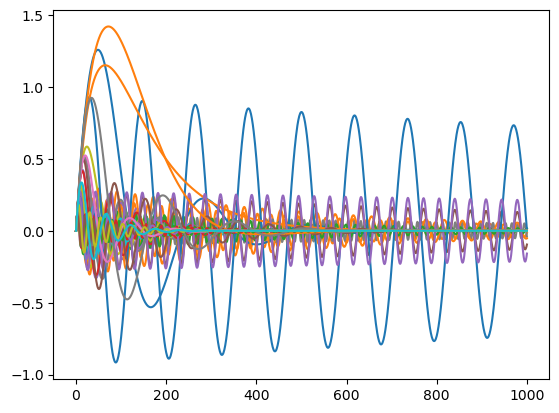

In [23]:
for i in range(40):
    plt.plot(x_train[i])